In [357]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

In [358]:
DATA_PATH = "./Emotion_classify_Data.csv"

PLOT_COLORS = ["red", "green", "blue"]

EMBEDDING_DIMENSIONS = 100

EPOCHS = 100
BATCH_SIZE = 32

In [359]:
def load_data() -> pd.DataFrame:
    return pd.read_csv(DATA_PATH)

def get_vocabulary(column_with_docs: str, dataframe: pd.DataFrame) -> set:
    documents: list[str] = dataframe[column_with_docs].to_list()
    documents_text: str = " ".join(documents)
    vocabulary: set = set(documents_text.split(" "))
    return vocabulary

def convert_word_to_index(vocabulary: set) -> dict:
    word2indx = {word: index for index, word in enumerate(vocabulary)}
    return word2indx

def create_features_table(unique_values: list) -> dict:
    features_table: dict = {}
    feature_code: int = 0
    for unique_value in unique_values:
        features_table[unique_value] = feature_code
        feature_code += 1
    return features_table

def encode_classes(feature_table: dict, dataframe: pd.DataFrame) -> pd.DataFrame:
    new_df: pd.DataFrame = dataframe.copy()
    
    for k, v in feature_table.items():
        new_df["Emotion"][new_df["Emotion"] == k] = v
    
    return new_df

def vectorize_sentence(word2indx: dict, sentence: str) -> list[int]:
    sentence = sentence.lower().split(" ")
    vector = [word2indx[word] for word in sentence]
    return vector

def convert_to_embedding(emb_layer: nn.Embedding, vector: list[int]) -> torch.LongTensor:
    return emb_layer(torch.LongTensor(vector))

def plot_emotions_distribution(loaded_dataframe: pd.DataFrame):
    emotions = loaded_dataframe["Emotion"].unique()
    emotions_count = []
    for emotion in emotions:
        emotion_doc_counter = len(loaded_dataframe[loaded_dataframe["Emotion"] == emotion])
        emotions_count.append(emotion_doc_counter)
    
    _, ax = plt.subplots()
    ax.bar(emotions, emotions_count, label=emotions, color=PLOT_COLORS)
    ax.set_title("Emotions distribution")
    plt.show()
    

In [360]:
emotion_data = load_data()

In [361]:
emotion_data.head()

,Comment,Emotion
0,i seriously hate one subject to death but now ...,fear
1,im so full of life i feel appalled,anger
2,i sit here to write i start to dig out my feel...,fear
3,ive been really angry with r and i feel like a...,joy
4,i feel suspicious if there is no one outside l...,fear


In [362]:
emotion_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5937 entries, 0 to 5936
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Comment  5937 non-null   object
 1   Emotion  5937 non-null   object
dtypes: object(2)
memory usage: 92.9+ KB


In [363]:
emotion_data.isna().sum()

Comment    0
Emotion    0
dtype: int64

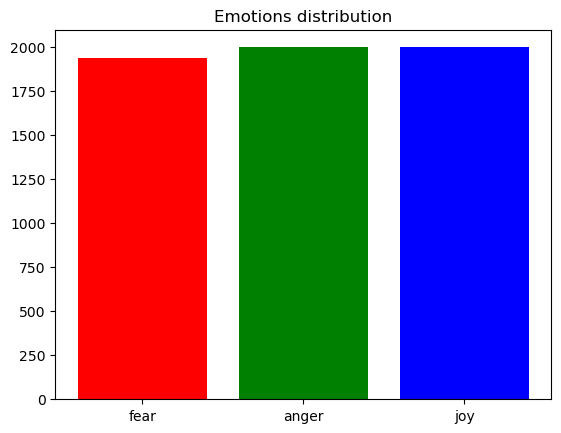

In [364]:
plot_emotions_distribution(emotion_data)

In [365]:
emotion_types = emotion_data["Emotion"].unique()
emotion_types_len = len(emotion_types)
emotion_types_encoding = create_features_table(emotion_types.tolist())
emotion_types, emotion_types_encoding

(array(['fear', 'anger', 'joy'], dtype=object),
 {'fear': 0, 'anger': 1, 'joy': 2})

In [366]:
vocabulary = get_vocabulary("Comment", emotion_data)

In [367]:
vocabulary_size = len(vocabulary)
vocabulary, vocabulary_size

({'von',
  'bullying',
  'biology',
  'waking',
  'voyeur',
  'orthodontist',
  'embrace',
  'brew',
  'nights',
  'saw',
  'negatively',
  'enjoyable',
  'regulated',
  'deals',
  'pariah',
  'seems',
  'fumes',
  'throw',
  'gentle',
  'gummy',
  'angry',
  'normal',
  'lifeline',
  'aren',
  'stretch',
  'affected',
  'purposely',
  'zombies',
  'love',
  'worst',
  'spitball',
  'youd',
  'simple',
  'cuts',
  'surface',
  'mighty',
  'heartburn',
  'height',
  'contacts',
  'say',
  'specific',
  'indicated',
  'meantime',
  'encourage',
  'retirement',
  'not',
  'dharavi',
  'study',
  'destination',
  'murmurs',
  'again',
  'disadvantaged',
  'venerate',
  'kinda',
  'jennifer',
  'nonchalant',
  'gave',
  'closing',
  'triggered',
  'pig',
  'handbrake',
  'cancelled',
  'office',
  'energy',
  'bigotry',
  'nicely',
  'diminishing',
  'reduce',
  'sadly',
  'grasp',
  'worrying',
  'andintrupte',
  'witches',
  'jar',
  'cantankerous',
  'bill',
  'vile',
  'considered',
  '

In [368]:
word2indx = convert_word_to_index(vocabulary)

In [369]:
word2indx

{'von': 0,
 'bullying': 1,
 'biology': 2,
 'waking': 3,
 'voyeur': 4,
 'orthodontist': 5,
 'embrace': 6,
 'brew': 7,
 'nights': 8,
 'saw': 9,
 'negatively': 10,
 'enjoyable': 11,
 'regulated': 12,
 'deals': 13,
 'pariah': 14,
 'seems': 15,
 'fumes': 16,
 'throw': 17,
 'gentle': 18,
 'gummy': 19,
 'angry': 20,
 'normal': 21,
 'lifeline': 22,
 'aren': 23,
 'stretch': 24,
 'affected': 25,
 'purposely': 26,
 'zombies': 27,
 'love': 28,
 'worst': 29,
 'spitball': 30,
 'youd': 31,
 'simple': 32,
 'cuts': 33,
 'surface': 34,
 'mighty': 35,
 'heartburn': 36,
 'height': 37,
 'contacts': 38,
 'say': 39,
 'specific': 40,
 'indicated': 41,
 'meantime': 42,
 'encourage': 43,
 'retirement': 44,
 'not': 45,
 'dharavi': 46,
 'study': 47,
 'destination': 48,
 'murmurs': 49,
 'again': 50,
 'disadvantaged': 51,
 'venerate': 52,
 'kinda': 53,
 'jennifer': 54,
 'nonchalant': 55,
 'gave': 56,
 'closing': 57,
 'triggered': 58,
 'pig': 59,
 'handbrake': 60,
 'cancelled': 61,
 'office': 62,
 'energy': 63,
 'bi

In [370]:
embedding_layer = nn.Embedding(vocabulary_size, EMBEDDING_DIMENSIONS)
test_sentence: str = np.random.choice(emotion_data["Comment"].to_list())
formatted_test_sentence: str = test_sentence.lower().split(" ")
sentence_w2indx: list[int] = [word2indx[word] for word in formatted_test_sentence]
sentence_vector = embedding_layer(torch.LongTensor(sentence_w2indx))
print(f"Test sentence: {formatted_test_sentence}\nVector:{sentence_vector}")

Test sentence: ['im', 'feeling', 'pissed', 'and', 'sad', 'right', 'now']
Vector:tensor([[-1.5859,  0.3358,  0.4992, -0.7857, -0.0128,  1.2818, -1.9799,  0.9406,
          0.5064,  0.9138,  0.7074,  0.4945,  1.6128,  0.0113, -0.3078,  0.7577,
         -1.3484,  1.7718, -0.1206,  1.9827,  0.6475,  0.1858,  0.5471, -0.7541,
          1.9481,  0.7387,  0.2709,  0.7111,  0.5002, -1.1396, -0.7906, -0.3767,
         -0.7276,  0.9911,  1.6785, -1.9536, -0.2290, -0.6782, -0.8160,  1.2272,
         -2.0377,  0.7173,  1.6617, -0.6345, -1.6907, -0.3326, -2.3547,  0.1153,
          1.1149, -0.4624,  1.8900, -0.6147,  0.8699,  0.6983,  0.1417, -1.1944,
          0.4000, -0.7759,  0.4227, -0.1677, -2.0303, -0.5066, -2.3332,  1.8206,
          0.5496, -1.4474, -0.7176,  0.0540, -0.5564, -0.1960, -0.6240, -0.9383,
          0.0769,  1.6482,  0.7443, -0.5959,  1.2924,  1.9659, -1.6232, -0.4478,
          2.1619, -1.0999,  0.6308, -0.5866,  1.1985, -1.1861,  0.0271,  0.7118,
         -1.0448,  0.5036,  0

In [371]:
preprocessed_dataframe = encode_classes(emotion_types_encoding, emotion_data)
preprocessed_dataframe.head()

,Comment,Emotion
0,i seriously hate one subject to death but now ...,0
1,im so full of life i feel appalled,1
2,i sit here to write i start to dig out my feel...,0
3,ive been really angry with r and i feel like a...,2
4,i feel suspicious if there is no one outside l...,0


In [372]:
X, y = preprocessed_dataframe["Comment"], preprocessed_dataframe["Emotion"]
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)

In [373]:
X_train.head()

4246        i feel like a wimpy blubbering fool right now
93       the possibility of having failed the examination
2184    i had it in the bag because i was still feelin...
916     ive been feeling restless inside and i dont un...
1040                             i feel scared and stupid
Name: Comment, dtype: object

In [374]:
Y_train.head()

4246    0
93      0
2184    2
916     0
1040    0
Name: Emotion, dtype: object

In [392]:
class DatasetLoader(Dataset):
    def __init__(self, X, y) -> None:
        super(DatasetLoader, self).__init__()
        self.X = np.array(X)
        self.y = np.array(y)
        print(self.y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        vector = vectorize_sentence(word2indx, self.X[index])
        emb = convert_to_embedding(embedding_layer, vector)
        return emb, self.y[index]

In [393]:
train_set = DatasetLoader(X_train, Y_train)
test_set = DatasetLoader(X_test, Y_test)
train_iter = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_iter = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

[0 0 2 ... 1 1 0]
[2 0 2 ... 1 2 2]


In [394]:
x, y = next(iter(train_iter))
x, y

RuntimeError: stack expects each tensor to be equal size, but got [26, 100] at entry 0 and [39, 100] at entry 1

In [379]:
# model = MultiClassClassifier(embedding_layer)

# optimizer = torch.optim.Adam(model.parameters())
# criterion = nn.CrossEntropyLoss()